* Similar with CompleteMinLocValFre.ipynb, except this notebook contains time interpolation, exclude the average of value and loc.

In [1]:
from salishsea_tools import (nc_tools,viz_tools,geo_tools,tidetools)
from datetime import datetime, timedelta
from glob import glob
import matplotlib.pyplot as plt
import scipy.io as sio
import netCDF4 as nc
import numpy as np
import seaborn as sns
import os
import datetime
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
import sys
sys.path.append('/ocean/jieliu/research/meopar/salinity_comparison/')
import salinity3_copy

In [3]:
paths = {'nowcast': '/results/SalishSea/nowcast/',
        'longerresult': '/data/jieliu/MEOPAR/river-treatment/14days_norefraserxml/',
        'widenresult': '/data/jieliu/MEOPAR/river-treatment/14nor_NWSmoorerunMoreSubdomain/'}

In [4]:
def find_dist (q, lon11, lat11, X, Y, bathy, longitude, latitude, saline_nemo_2rd,\
               saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home):
    k=0
    values_2 =0
    values_3=0
    values_4=0
    values_5=0
    dist = np.zeros(9)
    weights = np.zeros(9)
    value_2rd=np.zeros(9)
    value_3rd=np.zeros(9)
    value_4rd=np.zeros(9)
    value_5rd=np.zeros(9)
    
    x1, j1 = geo_tools.find_closest_model_point(lon11[q],lat11[q],X,Y,land_mask=bathy.mask)
    if results_home == paths['nowcast'] or results_home == paths['longerresult']:
        x1 =x1;
        j1 = j1
    elif results_home == paths['widenresult']: ## this is subdomain
        x1 = x1-349;
        j1 = j1 - 200
    for i in np.arange(x1-1,x1+2):
         for j in np.arange(j1-1,j1+2):
            dist[k]=geo_tools.haversine(lon11[q],lat11[q],longitude[i,j],latitude[i,j])
            weights[k]=1.0/dist[k]
            value_2rd[k]=saline_nemo_2rd[i,j]*weights[k]
            value_3rd[k]=saline_nemo_3rd[i,j]*weights[k]
            value_4rd[k]=saline_nemo_4rd[i,j]*weights[k]
            value_5rd[k]=saline_nemo_5rd[i,j]*weights[k]
            values_2=values_2+value_2rd[k]
            values_3=values_3+value_3rd[k]
            values_4=values_4+value_4rd[k]
            values_5=values_5+value_5rd[k]
            k+=1
            
    return values_2,values_3,values_4,values_5, weights

In [5]:
def salinity_fxn_norm(saline, run_date, results_home, run_lower, run_upper):
    """The significance of this function was to return longitude,
       latitude, salinity values for observations, 1.5m of 3rd & 4rd, 
       3m average of 3rd & 4rd model result and the time selection for 
       saline_nemo_3rd or 4rd is in the middle """
    a=saline['ferryData']
    b=a['data']
    dataa = b[0,0]
    time=dataa['matlabtime'][0,0]
    lonn=dataa['Longitude'][0,0]
    latt=dataa['Latitude'][0,0]
    salinity=dataa['Practical_Salinity'][0,0]   
    
    a=len(time)
    lon1=np.zeros([a,1])
    lat1=np.zeros([a,1])
    salinity1=np.zeros([a,1])
    time_matlab = []
    for i in np.arange(0,a):
        matlab_datenum = np.float(time[i]);
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366);
        time_matlab.append(python_datetime)
        
        if(python_datetime >= run_lower) &(python_datetime <= run_upper):
            lon1[i]=lonn[i]
            lat1[i]=latt[i]
            salinity1[i]=salinity[i]
            
    mask=lon1[:,0]!=0
    lon1_2_4=lon1[mask]
    lat1_2_4=lat1[mask]
    salinity1_2_4=salinity1[mask]
    time1_2_4 = np.array(time_matlab)[mask]
    lon11=lon1_2_4[0:-1:20]
    lat11=lat1_2_4[0:-1:20]
    salinity11=salinity1_2_4[0:-1:20]
    time11 = time1_2_4[0:-1:20]
    date_str = run_date.strftime('%d-%b-%Y')
    
    if results_home == paths['nowcast']:
        bathyold, X, Y = salinity3_copy.get_SS2_bathy_data()   
    elif results_home ==paths['longerresult']:
        bathynew5, X, Y = salinity3_copy.get_SS5_bathy_data()
    else:
        bathynew6, X, Y = salinity3_copy.get_SS6_bathy_data()

    if results_home == paths['nowcast'] or results_home ==paths['longerresult']:
    ## if nowcast of bathy5, the result file is whole domain  
        filepath_name = salinity3_copy.date(run_date.year,run_date.month, run_date.day,\
        run_date.day,run_date.day, results_home,'1h','grid_T') 
        tracers=nc.Dataset(filepath_name[0])
    elif results_home ==paths['widenresult']:
        tracers=nc.Dataset(paths['widenresult']+'1hplume06160629smooLargestgridT.nc')
        
    latitude=tracers.variables['nav_lat'][:] 
    longitude=tracers.variables['nav_lon'][:] 
    saline_nemo = tracers.variables['vosaline']

    matrix=np.zeros([len(lon11),9])
    values_2=np.zeros([len(lon11),1])
    values_3=np.zeros([len(lon11),1])
    values_4=np.zeros([len(lon11),1])
    values_5=np.zeros([len(lon11),1])
    value_mean_2rd_hour=np.zeros([len(lon11),1])
    value_mean_3rd_hour=np.zeros([len(lon11),1])
    value_mean_4rd_hour=np.zeros([len(lon11),1])
    value_mean_5rd_hour=np.zeros([len(lon11),1])
    if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 or\
        run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==17 or run_lower.hour ==22:
        if run_lower.hour ==0 or run_lower.hour ==5 or run_lower.hour == 14 or run_lower.hour == 19 : 
            if results_home == paths['nowcast'] or results_home ==paths['longerresult']:
                saline_nemo_2rd = saline_nemo[run_lower.hour, 1] 
                saline_nemo_3rd = saline_nemo[run_lower.hour +1,1] 
                saline_nemo_4rd = saline_nemo[run_lower.hour +2 ,1]
                saline_nemo_5rd = saline_nemo[run_lower.hour +3 ,1]
            elif results_home ==paths['widenresult']:
                saline_nemo_2rd = saline_nemo[run_lower.hour + (run_date.day-16)*24, 1] 
                saline_nemo_3rd = saline_nemo[run_lower.hour +1 + (run_date.day-16)*24,1] 
                saline_nemo_4rd = saline_nemo[run_lower.hour +2 + (run_date.day-16)*24,1]
                saline_nemo_5rd = saline_nemo[run_lower.hour +3 + (run_date.day-16)*24,1]
                
        elif run_lower.hour ==3 or run_lower.hour ==12 or run_lower.hour ==17 or run_lower.hour ==22:
            if results_home ==paths['nowcast'] or results_home ==paths['longerresult']:
                saline_nemo_2rd = saline_nemo[run_lower.hour-1 , 1] 
                saline_nemo_3rd = saline_nemo[run_lower.hour, 1] 
                saline_nemo_4rd = saline_nemo[run_lower.hour +1,  1]
            elif results_home ==paths['widenresult']:
                saline_nemo_2rd = saline_nemo[run_lower.hour-1 + (run_date.day-16)*24, 1] 
                saline_nemo_3rd = saline_nemo[run_lower.hour + (run_date.day-16)*24, 1] 
                saline_nemo_4rd = saline_nemo[run_lower.hour +1 + (run_date.day-16)*24, 1]
                
            if run_lower.hour ==22 and run_lower.day ==29: ## if lower is 22 pm on June 29, after 23:30 still use 23:30 value
                saline_nemo_5rd = np.zeros(saline_nemo[run_lower.hour, 1].shape)
                
            elif run_lower.hour ==22 and run_lower.day !=29:
                if results_home == paths['nowcast'] or results_home ==paths['longerresult']:
                    filepath_name = salinity3_copy.date(run_date.year,run_date.month, run_date.day+1,\
                    run_date.day+1,run_date.day+1, results_home,'1h','grid_T') 
                    tracers_forward=nc.Dataset(filepath_name[0])
                    saline_nemo_forward = tracers_forward.variables['vosaline']
                    saline_nemo_5rd = saline_nemo_forward[0,1]
                elif results_home ==paths['widenresult']:
                    tracers_forward=nc.Dataset(paths['widenresult']+'1hplume06160629smooLargestgridT.nc')
                    saline_nemo_forward = tracers_forward.variables['vosaline']
                    saline_nemo_5rd = saline_nemo_forward[(run_date.day+1 -16)*24,1] ## next day's 0:30 am
            else:
                if results_home == paths['nowcast'] or results_home ==paths['longerresult']:
                    saline_nemo_5rd = saline_nemo[run_lower.hour+2 ,1]
                elif results_home ==paths['widenresult']:
                    saline_nemo_5rd = saline_nemo[run_lower.hour+2 + (run_date.day-16)*24,1]

        for q in np.arange(0,len(lon11)):
            if (~np.isnan(lon11[q])) and (~np.isnan(lat11[q])):
                if results_home == paths['nowcast']:
                    #print(lon11[q],lat11[q])
                    values_2[q], values_3[q],values_4[q],values_5[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                        bathyold, longitude, latitude, \
                                        saline_nemo_2rd,saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home)
                    value_mean_2rd_hour[q]=values_2[q]/sum(matrix[q])
                    value_mean_3rd_hour[q]=values_3[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=values_4[q]/sum(matrix[q])
                    value_mean_5rd_hour[q]=values_5[q]/sum(matrix[q])

                elif results_home ==paths['longerresult']:
                    values_2[q], values_3[q],values_4[q],values_5[q], matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                            bathynew5, longitude, latitude,\
                                            saline_nemo_2rd,saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home)
                    value_mean_2rd_hour[q]=values_2[q]/sum(matrix[q])
                    value_mean_3rd_hour[q]=values_3[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=values_4[q]/sum(matrix[q])
                    value_mean_5rd_hour[q]=values_5[q]/sum(matrix[q])
                    
                elif results_home ==paths['widenresult']:
                    values_2[q], values_3[q],values_4[q],values_5[q],matrix[q,:]=find_dist(q, lon11, lat11, X, Y,\
                                                 bathynew6, longitude, latitude,\
                                                saline_nemo_2rd,saline_nemo_3rd, saline_nemo_4rd,saline_nemo_5rd,results_home)
                    value_mean_2rd_hour[q]=values_2[q]/sum(matrix[q])
                    value_mean_3rd_hour[q]=values_3[q]/sum(matrix[q])
                    value_mean_4rd_hour[q]=values_4[q]/sum(matrix[q])
                    value_mean_5rd_hour[q]=values_5[q]/sum(matrix[q])

        #print(value_mean_3rd_hour.shape,value_mean_3rd_hour)
    else:
        value_mean_3rd_hour[:] = np.nan
        value_mean_4rd_hour[:] = np.nan     
    #elif results_home ==paths['widenresult']: ## if subdomain file
        #date_str = run_date.strftime('%d-%b-%Y') 
        #value_mean_3rd_hour, value_mean_4rd_hour= salinity_along_track_bathy6\
        #(results_home,run_date,run_lower,run_upper,lon11,lat11,X,Y,bathynew6)

    return lon11, lat11, lon1_2_4, lat1_2_4,\
    value_mean_2rd_hour, value_mean_3rd_hour, \
    value_mean_4rd_hour, value_mean_5rd_hour,\
    salinity11, salinity1_2_4, date_str,time11

In [6]:
def min_salinity_test(days,results_home):
    """This function was made to plot ferry 1.5m/average 3m salinity with different cases vs ferry salinity
        and there differences. should consider set up value_mean_4rd as {}"""
    sal_min_obs = []; lon_obs = [];sal_min_15 = [];lon_15=[]; fresh_obs = [];fresh_15 = []
    for day in days:
        for i in np.arange(24):
            if i < 12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201506%s.mat' %(day))
            elif i>=12:
                saline = sio.loadmat('/ocean/jieliu/research/meopar/autodataupdate/ferrydata/SBE19201506%s.mat' %(day+1))
            ## read in run_date, run_lower and run_upper for each trip case.
            run_date = datetime.datetime(2015,6,day+1)
            if i == 0 or i ==5 or i==14 or i==19 :
                run_lower = run_date.replace(hour = i, minute = 45)
                if i ==0:
                    run_upper = run_date.replace(hour = 3, minute = 15)
                else:
                    run_upper = run_lower.replace(hour = i+2)                
            elif i == 3 or i==12 or i==17 or i==22:
                run_lower = run_date.replace(hour = i, minute = 15)
                if i == 22:
                    run_upper = run_date.replace(day = day+2,hour = 0, minute = 15)
                else:
                    run_upper = run_lower.replace(hour = i+2)
            ##extract values from ferry route   
            if i == 0 or i==3 or i==5 or i ==12 or i ==14 or i==17 or i==19 or i ==22:
                lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_2rd_deep, value_mean_3rd_deep, \
                value_mean_4rd_deep, value_mean_5rd_deep,\
                salinity11, salinity1_2_4, date_str, time_ferry = salinity_fxn_norm\
                (saline, run_date, results_home,run_lower,run_upper)
                
                 ## Time interpolation
                value_mean_final = time_interp(value_mean_2rd_deep, value_mean_3rd_deep, \
                value_mean_4rd_deep, value_mean_5rd_deep, time_ferry)
                ## find min salinity value and location along ferry route and freshwater amount

                salinity_min_obs, lon_min_obs, salinity_min_15,lon_min_15 =find_min_value_location\
                (run_date, results_home, saline, run_lower, run_upper,lon_model, lat_model, lon1_model, lat1_model,\
                value_mean_final, salinity11, salinity1_2_4, date_str)
                
                fresh_obsInd, fresh_15Ind = freshwater(results_home,lon_model, lat_model, \
                                                            lon1_model, lat1_model,salinity1_2_4,value_mean_final)
            else: 
                salinity_min_obs= np.nan;lon_min_obs=np.nan;salinity_min_15=np.nan;lon_min_15=np.nan;
                fresh_obsInd = np.nan; fresh_15Ind= np.nan
            ## append the values to a list
            sal_min_obs.append(salinity_min_obs);
            lon_obs.append(float(lon_min_obs));
            sal_min_15.append(salinity_min_15);
            lon_15.append(float(lon_min_15));
            fresh_obs.append(fresh_obsInd);
            fresh_15.append(fresh_15Ind)

    return sal_min_obs, lon_obs, sal_min_15,lon_15, fresh_obs,fresh_15

In [7]:
def time_interp(value_mean_2rd_deep, value_mean_3rd_deep, \
                value_mean_4rd_deep, value_mean_5rd_deep,time):
    """
    Linear time interpolation between continuous hour model results
    """
    value_final = np.zeros(len(time))
    
    if len(time) !=0: ## important, on June 21 time length is 0
        print(time[0],len(time), np.nansum(value_mean_3rd_deep),value_final.shape)
        if time[0].hour ==0 or time[0].hour == 5 or time[0].hour == 14 or time[0].hour ==19:
            low = time[0].replace(minute = 30)
            mid = low.replace(hour = low.hour+1)
            high = mid.replace(hour = mid.hour+1)
            Hhigh = high.replace(hour = high.hour+1)
        elif time[0].hour ==3 or time[0].hour == 17 or time[0].hour == 22 or time[0].hour == 12:           
            low = time[0].replace(hour = time[0].hour-1, minute = 30)
            mid = low.replace(hour = low.hour+1)
            high = mid.replace(hour = mid.hour+1)
            if time[0].hour == 22:
                Hhigh = high.replace(day = high.day+1,hour = 0)
            else:
                Hhigh = high.replace(hour = high.hour+1)

        for i,j in enumerate(time):
            if (j > low) and (j<mid):
                value_final[i] = (value_mean_2rd_deep[i]/((j-low).seconds/60) + \
                                  value_mean_3rd_deep[i]/((mid-j).seconds/60))/\
                                (1/((j-low).seconds/60)+1/((mid-j).seconds/60))
            elif (j > mid) and (j<high):
                value_final[i] = (value_mean_3rd_deep[i]/((j-mid).seconds/60) + \
                                  value_mean_4rd_deep[i]/((high-j).seconds/60))/\
                                (1/((j-mid).seconds/60)+1/((high-j).seconds/60))
            elif (j > high) and (j<Hhigh):
                if j.day == 29 and j.hour == 23 and j.minute >=30: ## june 29, exceed 23:30, use 23:30 value
                    value_final[i] = value_mean_4rd_deep[i]
                else:    
                    value_final[i] = (value_mean_4rd_deep[i]/((j-high).seconds/60) + \
                                  value_mean_5rd_deep[i]/((Hhigh-j).seconds/60))/\
                                (1/((j-high).seconds/60)+1/((Hhigh-j).seconds/60))
            if j == low:
                value_final[i] = value_mean_2rd_deep[i]
            if j == mid:
                value_final[i] = value_mean_3rd_deep[i]
            if j == high:
                value_final[i] = value_mean_4rd_deep[i]
            if j == Hhigh:
                value_final[i] = value_mean_5rd_deep[i]

    return value_final

In [8]:
def find_min_value_location(run_date, results_home, saline, run_lower, run_upper,lon11, lat11,\
                                 lon1_2_4, lat1_2_4, value_final,salinity11, salinity1_2_4,date_str):
    """This function was made to find out the minimum salinity value
       and longitude for observation and time interpolated 1.5m model result."""
    
    ##For observation
    if len(salinity1_2_4) ==0:
        salinity_min_obs = np.nan
        lon_min_obs=np.nan
    else:
        salinity_min_obs = np.nanmin(salinity1_2_4)
        ind_obs = np.nanargmin(salinity1_2_4)
        lon_min_obs = lon1_2_4[ind_obs]
    
    ## For nowcast or new model result with 1.5m depth for 3rd model time 
    ## no length or all nan or all 0, then set to nan
    if (len(value_final) ==0) or (np.nansum(value_final) ==np.nan) or (np.nansum(value_final) ==0):
        
        salinity_min_15 = np.nan
        lon_min_15=np.nan

    else:
        value_final[value_final==0]=np.nan ## 12:15 ferry the first value of model result is always 0
        salinity_min_15 = np.nanmin(value_final)## some cases when part of them are 0
        ## since it is subdomain
        ind_15 = np.nanargmin(value_final)
        lon_min_15 = lon11[ind_15]
    
    return salinity_min_obs, lon_min_obs, salinity_min_15,lon_min_15

In [9]:
def freshwater(results_home,lon11, lat11, lon1_2_4, lat1_2_4,salinity1_2_4,value_final):
    salinity1_2_4[np.isnan(salinity1_2_4)] = 30 ##set nan to 30 psu for observation
    #print(len(lon1_2_4))
    if len(lon1_2_4) != 0:
        obs_Sdx = np.zeros(len(lon1_2_4)-1) ## index from 0 to 718
        mod_new_15Sdx = np.zeros(len(lon11)-1)

        length_obs = np.arange(len(lon1_2_4)-1)
        length_mod = np.arange(len(lon11) - 1)
        ## For observation:
        for i in length_obs:
            obs_Sdx[i] = (30 - salinity1_2_4[:,0][i]) * np.abs(np.diff(lon1_2_4[:,0])[i]) * \
            111000 * np.cos(np.pi*lat1_2_4[i]/180) #discrete outcome by multiplying 
        obs_total_integral = np.cumsum(obs_Sdx)
        max_amount_obs = max(obs_total_integral)
        ## For model results:    
        for j in length_mod:
            if value_final[j] !=0: ## 12:15 ferry data the first value of model is always 0, exclude for freshwater here
                mod_new_15Sdx[j] = (30 - value_final[j]) * np.abs(np.diff(lon11[:,0])[j]) * \
                111000 * np.cos(np.pi*lat11[j]/180)  
        mod_total_new_15integral = np.cumsum(mod_new_15Sdx)
        ## Find max for 1.5m 
        max_mod_new15 = max(mod_total_new_15integral)
    else:
        max_amount_obs = np.nan
        max_mod_new15 = np.nan

    return max_amount_obs, max_mod_new15

In [10]:
## test for nowcasts
days = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sal_min_obs,lon_obs,sal_now,lon_now,fre_obs,fre_now= min_salinity_test(days,paths['nowcast'])

2015-06-16 00:45:02.642995 45 1027.30594403 (45,)
2015-06-16 03:15:02.803995 36 768.037643683 (36,)
2015-06-16 05:45:02.864995 35 738.623683146 (35,)
2015-06-16 12:16:13.295998 36 707.123660313 (36,)
2015-06-16 14:45:03.430995 36 702.151707197 (36,)
2015-06-16 17:15:03.968003 36 700.053963859 (36,)
2015-06-16 19:45:04.201000 36 725.700905483 (36,)
2015-06-16 22:15:04.134994 36 707.368376969 (36,)
2015-06-17 00:45:04.079006 45 991.656251092 (45,)
2015-06-17 03:15:04.237994 36 777.410994952 (36,)
2015-06-17 05:45:04.376001 33 662.449406071 (33,)
2015-06-17 12:21:24.733999 35 694.314702762 (35,)
2015-06-17 14:45:04.857993 36 716.672783152 (36,)
2015-06-17 17:15:05.408993 36 689.749595901 (36,)
2015-06-17 19:45:05.234991 36 726.548518514 (36,)
2015-06-17 22:15:06.014002 36 740.940490533 (36,)
2015-06-18 00:45:05.947001 45 994.192211817 (45,)
2015-06-18 03:15:06.104993 36 766.955295344 (36,)
2015-06-18 05:45:05.577000 34 650.045582516 (34,)
2015-06-18 12:15:36.343996 36 670.312302187 (36,)


In [11]:
## test for bathy5
days = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sal_min_obs,lon_obs,sal_bathy5,lon_bathy5,fre_obs,fre_15= min_salinity_test(days,paths['longerresult'])

2015-06-16 00:45:02.642995 45 1014.50688615 (45,)
2015-06-16 03:15:02.803995 36 757.019312787 (36,)
2015-06-16 05:45:02.864995 35 738.410890766 (35,)
2015-06-16 12:16:13.295998 36 706.120908245 (36,)
2015-06-16 14:45:03.430995 36 707.395807072 (36,)
2015-06-16 17:15:03.968003 36 692.300248028 (36,)
2015-06-16 19:45:04.201000 36 723.469937339 (36,)
2015-06-16 22:15:04.134994 36 699.050410669 (36,)
2015-06-17 00:45:04.079006 45 972.552341509 (45,)
2015-06-17 03:15:04.237994 36 757.998076378 (36,)
2015-06-17 05:45:04.376001 33 639.198161397 (33,)
2015-06-17 12:21:24.733999 35 679.877061122 (35,)
2015-06-17 14:45:04.857993 36 701.620676762 (36,)
2015-06-17 17:15:05.408993 36 675.549184736 (36,)
2015-06-17 19:45:05.234991 36 719.355379214 (36,)
2015-06-17 22:15:06.014002 36 729.327390002 (36,)
2015-06-18 00:45:05.947001 45 989.642904141 (45,)
2015-06-18 03:15:06.104993 36 765.304893227 (36,)
2015-06-18 05:45:05.577000 34 635.006630194 (34,)
2015-06-18 12:15:36.343996 36 666.712917569 (36,)


In [12]:
## test for bathy6
days = [15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sal_min_obs,lon_obs,sal_bathy6,lon_bathy6,fre_obs,fre_16= min_salinity_test(days,paths['widenresult'])

2015-06-16 00:45:02.642995 45 1008.44696051 (45,)
2015-06-16 03:15:02.803995 36 786.564697157 (36,)
2015-06-16 05:45:02.864995 35 756.84724957 (35,)
2015-06-16 12:16:13.295998 36 719.749221776 (36,)
2015-06-16 14:45:03.430995 36 718.062410795 (36,)
2015-06-16 17:15:03.968003 36 716.644287438 (36,)
2015-06-16 19:45:04.201000 36 735.128066312 (36,)
2015-06-16 22:15:04.134994 36 728.802862595 (36,)
2015-06-17 00:45:04.079006 45 970.996641601 (45,)
2015-06-17 03:15:04.237994 36 762.123279517 (36,)
2015-06-17 05:45:04.376001 33 654.009786261 (33,)
2015-06-17 12:21:24.733999 35 699.834941871 (35,)
2015-06-17 14:45:04.857993 36 716.654062273 (36,)
2015-06-17 17:15:05.408993 36 704.572966853 (36,)
2015-06-17 19:45:05.234991 36 717.281878676 (36,)
2015-06-17 22:15:06.014002 36 747.228535636 (36,)
2015-06-18 00:45:05.947001 45 973.849488223 (45,)
2015-06-18 03:15:06.104993 36 744.896361133 (36,)
2015-06-18 05:45:05.577000 34 637.311509845 (34,)
2015-06-18 12:15:36.343996 36 683.169705795 (36,)
2

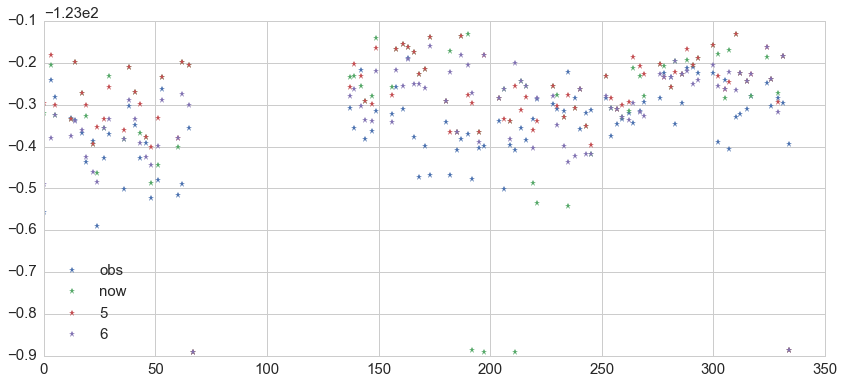

In [13]:
fig,ax = plt.subplots(1,1,figsize = (14,6))
ax.plot(lon_obs,'*',label='obs')
ax.plot(lon_now,'*',label ='now')
ax.plot(lon_bathy5,'*',label ='5')
ax.plot(lon_bathy6,'*',label ='6')
ax.legend(loc = 'best')

In [14]:
## value & loc & freshwater
## note June 18 22:45, 19, 20 until 14:45 of 21 no data and value
##get rid of five other unreasonable values
for i in [67,192,197,211,334]:
    sal_now[i] = np.nan
    sal_bathy5[i] = np.nan
    sal_bathy6[i] = np.nan
    sal_min_obs[i] = np.nan
    lon_now[i] = np.nan
    lon_bathy5[i] = np.nan
    lon_bathy6[i] = np.nan
    lon_obs[i] = np.nan
    fre_now[i] = np.nan
    fre_15[i] = np.nan
    fre_16[i] = np.nan
    fre_obs[i] = np.nan

In [15]:
## freshwater
fresh_obs_ave = []
fresh_nowcast_ave = []
fresh_bathy5_ave = []
fresh_bathy6_ave = [];
for i in np.arange(0,336,24):
    fresh_obs_ave.append(np.nanmean(fre_obs[i:i+24]))
    fresh_nowcast_ave.append(np.nanmean(fre_now[i:i+24]))
    fresh_bathy5_ave.append(np.nanmean(fre_15[i:i+24]))
    fresh_bathy6_ave.append(np.nanmean(fre_16[i:i+24]))
for i in np.arange(3,5):
    fresh_obs_ave[i] = np.nan ## June 19,20 no data actually
    fresh_nowcast_ave[i] = np.nan
    fresh_bathy5_ave[i]=np.nan
    fresh_bathy6_ave[i] = np.nan

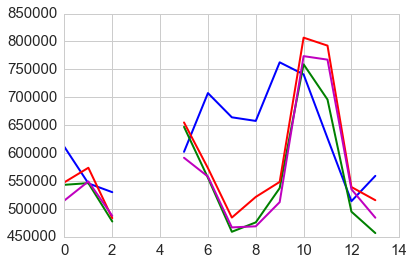

In [16]:
plt.plot(fresh_obs_ave,'b')
plt.plot(fresh_nowcast_ave,'g')
plt.plot(fresh_bathy5_ave,'r')
plt.plot(fresh_bathy6_ave,'m')

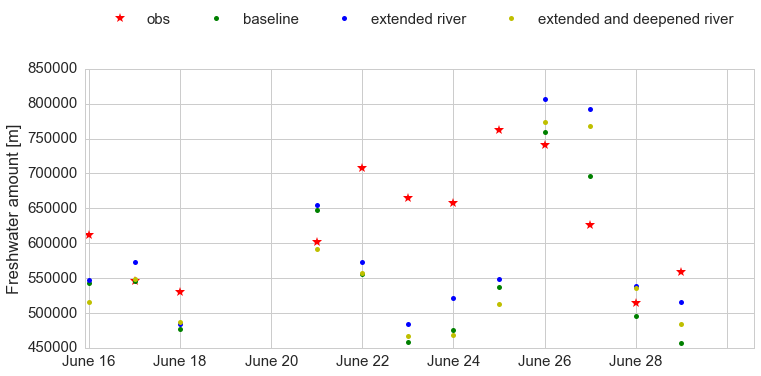

In [17]:
t = np.arange(14)
size = 10
fig,axs = plt.subplots(1,1,figsize = (12,5))

axs.plot(t,fresh_obs_ave,'r*',label = 'obs', markersize = size)
axs.plot(t,fresh_nowcast_ave,'g.',label = 'baseline', markersize = size)
axs.plot(t,fresh_bathy5_ave,'b.',label ='extended river', markersize = size)
axs.plot(t,fresh_bathy6_ave,'y.',label = 'extended and deepened river', markersize = size)
axs.set_ylabel('Practical Salinity')
axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=5, fancybox=False, shadow=True)
xticks, xticklabels = plt.xticks()
xmin = -0.1
xmax = xticks[-1]+0.6
axs.set_ylabel('Freshwater amount [m]')
x = range(0,16,2)
axs.set_xlim(xmin, xmax)
axs.set_xticks(x)
axs.set_xticklabels( ['June 16','June 18','June 20','June 22','June 24','June 26','June 28'] )

* Usually, model result is saltier than observation from plots of minimum salinity and freshwater amount. Location of plume is close to Vancouver compared with observation, which indicates discrepency of plume position. Our plume could not propagate further away cross the strait, other external forcing, such as wind should be taken into consideration. What about comparing wind in the model with observed wind?? 

# Bar graph for min salinity value and location

* Bias

In [18]:
## value
diff_sal_now = np.nanmean(np.array(sal_now)-np.array(sal_min_obs))
diff_sal_bathy5 = np.nanmean(np.array(sal_bathy5)-np.array(sal_min_obs))
diff_sal_bathy6 = np.nanmean(np.array(sal_bathy6)-np.array(sal_min_obs))
## std
std_sal_now = np.nanstd(np.array(sal_now)-np.array(sal_min_obs))
std_sal_bathy5 = np.nanstd(np.array(sal_bathy5)-np.array(sal_min_obs))
std_sal_bathy6 = np.nanstd(np.array(sal_bathy6)-np.array(sal_min_obs))

In [19]:
## loc
diff_sal_now_loc = np.nanmean(np.array(lon_now)-np.array(lon_obs))
diff_sal_bathy5_loc = np.nanmean(np.array(lon_bathy5)-np.array(lon_obs))
diff_sal_bathy6_loc = np.nanmean(np.array(lon_bathy6)-np.array(lon_obs))
## std
std_sal_now_loc = np.nanstd(np.array(lon_now)-np.array(lon_obs))
std_sal_bathy5_loc = np.nanstd(np.array(lon_bathy5)-np.array(lon_obs))
std_sal_bathy6_loc = np.nanstd(np.array(lon_bathy6)-np.array(lon_obs))

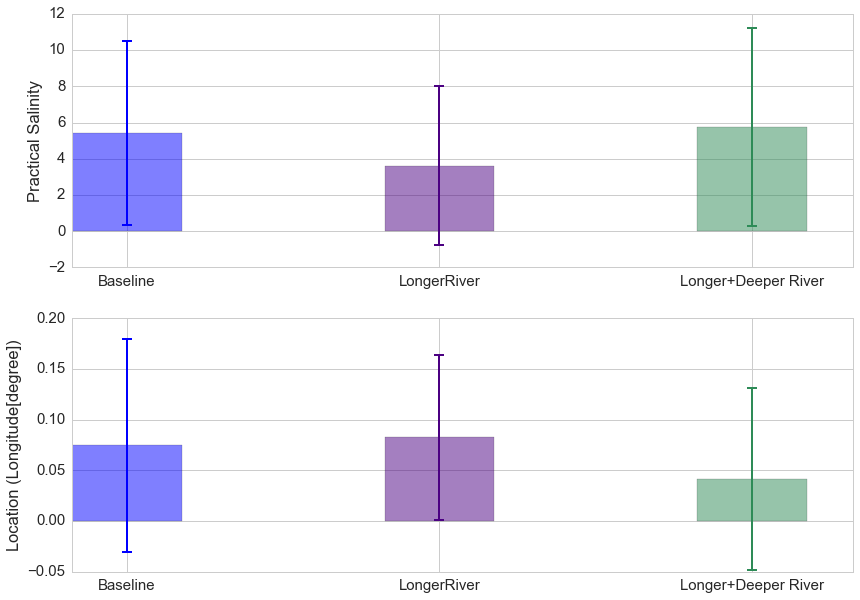

In [20]:
fig, axs = plt.subplots(2,1,figsize = [14,10])
diff_values = [diff_sal_now,diff_sal_bathy5,diff_sal_bathy6]
ind = np.arange(len(diff_values))
colors = ['b','Indigo','SeaGreen','r']
std_values = [std_sal_now,std_sal_bathy5,std_sal_bathy6]
diff_locs = [diff_sal_now_loc,diff_sal_bathy5_loc,diff_sal_bathy6_loc]
std_locs = [std_sal_now_loc,std_sal_bathy5_loc,std_sal_bathy6_loc]
width = 0.35
ax = axs[0] ## diff values
diff_value = ax.bar(ind, diff_values, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_values, std_values, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Practical Salinity')

ax =axs[1] ## diff locations
diff_loc = ax.bar(ind, diff_locs, width, color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_locs, std_locs, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Location (Longitude[degree])')
## xlabels
for ax in axs:
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('Baseline', 'LongerRiver', 'Longer+Deeper River'))

* RMS

In [21]:
## value
diff_sal_now = np.sqrt(np.nansum((np.array(sal_now)-np.array(sal_min_obs))**2)/86)
diff_sal_bathy5 = np.sqrt(np.nansum((np.array(sal_bathy5)-np.array(sal_min_obs))**2)/86)
diff_sal_bathy6 = np.sqrt(np.nansum((np.array(sal_bathy6)-np.array(sal_min_obs))**2)/86)
## std
std_sal_now = np.nanstd(np.sqrt((np.array(sal_now)-np.array(sal_min_obs))**2))
std_sal_bathy5 = np.nanstd(np.sqrt((np.array(sal_bathy5)-np.array(sal_min_obs))**2))
std_sal_bathy6 = np.nanstd(np.sqrt((np.array(sal_bathy6)-np.array(sal_min_obs))**2))

In [22]:
## loc
diff_sal_now_loc = np.sqrt(np.nansum((np.array(lon_now)-np.array(lon_obs))**2)/86)
diff_sal_bathy5_loc = np.sqrt(np.nansum((np.array(lon_bathy5)-np.array(lon_obs))**2)/86)
diff_sal_bathy6_loc = np.sqrt(np.nansum((np.array(lon_bathy6)-np.array(lon_obs))**2)/86)
## std
std_sal_now_loc = np.nanstd(np.sqrt((np.array(lon_now)-np.array(lon_obs))**2))
std_sal_bathy5_loc = np.nanstd(np.sqrt((np.array(lon_bathy5)-np.array(lon_obs))**2))
std_sal_bathy6_loc = np.nanstd(np.sqrt((np.array(lon_bathy6)-np.array(lon_obs))**2))

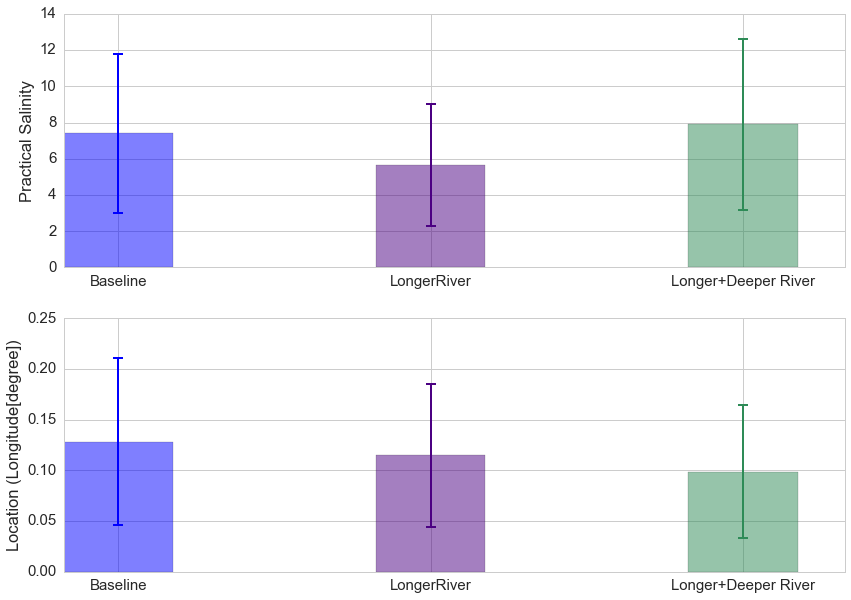

In [23]:
fig, axs = plt.subplots(2,1,figsize = [14,10])
diff_values = [diff_sal_now,diff_sal_bathy5,diff_sal_bathy6]
ind = np.arange(len(diff_values))
colors = ['b','Indigo','SeaGreen','r']
std_values = [std_sal_now,std_sal_bathy5,std_sal_bathy6]
diff_locs = [diff_sal_now_loc,diff_sal_bathy5_loc,diff_sal_bathy6_loc]
std_locs = [std_sal_now_loc,std_sal_bathy5_loc,std_sal_bathy6_loc]
width = 0.35
ax = axs[0] ## diff values
diff_value = ax.bar(ind, diff_values, width,color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_values, std_values, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Practical Salinity')

ax =axs[1] ## diff locations
diff_loc = ax.bar(ind, diff_locs, width, color=colors,alpha=0.5)
for pos, y, err, color in zip(ind, diff_locs, std_locs, colors):
    ax.errorbar(pos+width/2, y, err, lw=2, capsize=5, capthick=2, color=color)
ax.set_ylabel('Location (Longitude[degree])')
## xlabels
for ax in axs:
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('Baseline', 'LongerRiver', 'Longer+Deeper River'))